In [1]:
from typing import List
from copy import deepcopy
import pandas as pd

import ase
from ase import Atoms
from ase.calculators.lj import LennardJones
from ase.io import Trajectory
from ase.calculators.calculator import Calculator, all_changes

import numpy as np
import matplotlib.pyplot as plt

from cascade.utils import write_to_string, read_from_string

%load_ext autoreload
%autoreload 2

In [2]:
atoms = Atoms('N2')

In [3]:
atoms.positions

array([[0., 0., 0.],
       [0., 0., 0.]])

In [4]:
def sample_diatomic_distances(
    atoms_str: str = 'N2', 
    dist_range: tuple = (1.1, 3), 
    n: int = 100) -> List[ase.Atoms]:     
    """Create a trajectory of a diatomic system with linearly sampled distances
    atoms_str: ase specification of diatomic
    dist_range: (angsroms) range of distances to sample
    n: number of samples
    """
    atoms = Atoms(atoms_str)
    trajectory = []
    x_vals = np.linspace(*dist_range, n)
    for x in x_vals: 
        atoms = atoms.copy()
        atoms.set_positions([[0,0,0], [x, 0, 0]])
        trajectory.append(atoms)
    return trajectory

In [5]:
def apply_calculator(
    calc: ase.calculators.calculator.Calculator, 
    traj: List[ase.Atoms]) -> List[Atoms]:
    """Run a calculator on every atoms object in a list"""

    traj = deepcopy(traj)
    for atoms in traj: 
        atoms.calc = calc
        atoms.get_forces()
    return traj

In [6]:
def apply_calculator(
    calc: ase.calculators.calculator.Calculator, 
    traj: List[ase.Atoms]) -> pd.DataFrame:
    """Run a calculator on every atoms object in a list"""

    traj = deepcopy(traj)
    results = []
    for atoms in traj: 
        # todo: save the calculator on the atoms
        #       serialize/deserialize to cache singlepointcalculator
        calc.calculate(atoms)
        this_result = calc.results.copy()
        this_result['atoms'] = atoms.copy()
        this_result['position'] = atoms.positions[1,0]
        this_result['force'] = this_result[forces][0,0]
        results.append(this_result)
    return pd.DataFrame(results)

In [7]:
lj1, lj2  = LennardJones(sigma=1, eps=1), LennardJones(sigma=1, epsilon=1.1)

In [8]:
traj_base = sample_diatomic_distances()
traj_lj1  = apply_calculator(lj1, traj_base)
traj_lj2  = apply_calculator(lj2, traj_base)

NameError: name 'forces' is not defined

In [ ]:
plt.plot(traj_lj1['position'], traj_lj1['force'], label='$\epsilon=1$')
plt.plot(traj_lj2['position'], traj_lj2['force'], label='$\epsilon=1.1$')
plt.xlabel('$R_\mathrm{{N-N}}$ ($\mathrm{\AA}$)')
plt.ylabel('$F_{LJ}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.title('Lennard Jones Forces acting on N-N for varying $\epsilon$');

In [ ]:
plt.plot(traj_lj1['position'], (traj_lj1['force'] - traj_lj2['force']).abs(), label='$\epsilon=1$')
plt.title('Absolute force difference given $R_\mathrm{{N-N}}$ across LJ potentials')
plt.ylabel('$|F^{\epsilon=1}_{LJ} - F^{\epsilon=1.1}_{LJ}|$ (eV/$\mathrm{\AA}$)')
plt.xlabel('$R_\mathrm{{N-N}}$ ($\mathrm{\AA}$)')

## Ensemble Class

In [ ]:
from ase.calculators import EnsembleCalculator

In [243]:
ens = EnsembleCalculator([lj1, lj2])

In [244]:
traj_ens = apply_calculator(ens, traj_base)

In [245]:
traj_ens

,energy,forces,forces_std,atoms,position,force
0,-1.026788e+00,"[[-1.667500159315259, 0.0, 0.0], [1.6675001593...","[[0.07940476949120279, 0.0, 0.0], [0.079404769...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",1.100000,-1.667500
1,-1.043919e+00,"[[-0.20232675077248158, 0.0, 0.0], [0.20232675...","[[0.009634607179641985, 0.0, 0.0], [0.00963460...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",1.119192,-0.202327
2,-1.037351e+00,"[[0.8242651062531009, 0.0, 0.0], [-0.824265106...","[[0.03925071934538582, 0.0, 0.0], [0.039250719...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",1.138384,0.824265
3,-1.014347e+00,"[[1.5268258298786312, 0.0, 0.0], [-1.526825829...","[[0.07270599189898241, 0.0, 0.0], [0.072705991...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",1.157576,1.526826
4,-9.802686e-01,"[[1.9906089572711556, 0.0, 0.0], [-1.990608957...","[[0.09479090272719803, 0.0, 0.0], [0.094790902...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",1.176768,1.990609
...,...,...,...,...,...,...
95,-9.666399e-04,"[[0.01377092128040235, 0.0, 0.0], [-0.01377092...","[[0.0006557581562096366, 0.0, 0.0], [0.0006557...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",2.923232,0.013771
96,-7.083018e-04,"[[0.01315597545001709, 0.0, 0.0], [-0.01315597...","[[0.0006264750214293865, 0.0, 0.0], [0.0006264...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",2.942424,0.013156
97,-4.614639e-04,"[[0.012572164149470573, 0.0, 0.0], [-0.0125721...","[[0.0005986744833081249, 0.0, 0.0], [0.0005986...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",2.961616,0.012572
98,-2.255459e-04,"[[0.01201772916742203, 0.0, 0.0], [-0.01201772...","[[0.0005722728174962863, 0.0, 0.0], [0.0005722...","(Atom('N', [0.0, 0.0, 0.0], index=0), Atom('N'...",2.980808,0.012018


In [246]:
traj_ens['UQ'] = traj_ens['atoms'].map(lambda a: a.info['forces_std'][0,0])

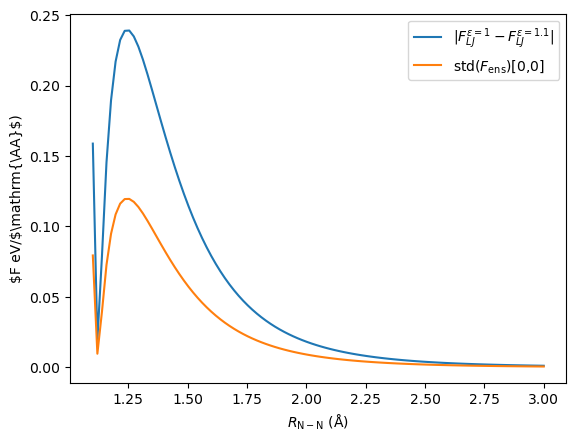

In [254]:
plt.plot(traj_lj1['position'], (traj_lj1['force'] - traj_lj2['force']).abs(), label='$|F^{\epsilon=1}_{LJ} - F^{\epsilon=1.1}_{LJ}|$')
plt.plot(traj_ens['position'], traj_ens['UQ'], label='std($F_\mathrm{ens}$)[0,0]')
plt.ylabel('$F eV/$\mathrm{\AA}$)')
plt.xlabel('$R_\mathrm{{N-N}}$ ($\mathrm{\AA}$)')
plt.legend()

In [261]:
traj_ens['atoms'][0].calc

## TODO import the auditors and try them out